In [60]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

In [61]:
train_df = pd.read_csv('AnalyticsOlympiad2022Data/train.csv')
test_df = pd.read_csv('AnalyticsOlympiad2022Data/test.csv')
submission_df = pd.read_csv('AnalyticsOlympiad2022Data/submission.csv')

In [3]:
train_df.head()

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
0,816393,40-64,female,20-29y,university,middle class,0.638050,0.0,after 2015,0.0,0.0,37379,11000.0,0,0,0,0.0,Sports Car
1,251762,26-39,male,20-29y,high school,middle class,0.475741,1.0,before 2015,1.0,0.0,10238,9000.0,0,0,0,1.0,HatchBack
2,481952,40-64,male,20-29y,none,middle class,0.839817,1.0,before 2015,1.0,1.0,10238,12000.0,0,0,0,1.0,Sedan
3,3506,40-64,male,20-29y,high school,upper class,0.682527,1.0,before 2015,0.0,1.0,92099,6000.0,1,0,0,1.0,Sedan
4,498013,40-64,female,20-29y,none,working class,0.572184,1.0,after 2015,1.0,1.0,32122,15000.0,0,0,1,0.0,Sedan


### Does not own the vehicle
### But claim was approved
### Does not have past accidents, speeding violations and DUIS
### Same postal code: 10238

In [ ]:
t1 = train_df[train_df['VEHICLE_OWNERSHIP']==0.0]
t2 = t1[t1['OUTCOME']==1.0]

In [10]:
t3 = t2[(t2['DUIS'] == 0) & (t2['SPEEDING_VIOLATIONS'] == 0) & (t2['PAST_ACCIDENTS'] == 0)]

In [14]:
print(t1.shape)
print(t2.shape)
print(t3.shape)
# 10238 POSTAL CODE

(18161, 18)
(7736, 18)
(3509, 18)


In [57]:
t3['ID'].value_counts(dropna=False)

138559    2
293637    2
1751      2
212859    2
320825    2
         ..
162077    1
334486    1
520507    1
306501    1
446079    1
Name: ID, Length: 3503, dtype: int64

In [59]:
t3[t3['ID'].isin([138559])]
# ,293637,1751,212859,320825

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
7753,138559,65+,male,20-29y,none,poverty,0.695805,0.0,after 2015,1.0,0.0,10238,14000.0,0,0,0,1.0,Sedan
31069,138559,16-25,male,0-9y,none,upper class,0.690901,0.0,after 2015,1.0,1.0,23655,9000.0,0,0,0,1.0,Sedan


In [30]:
t3['POSTAL_CODE'].value_counts(dropna=False)

10238    2615
92101      44
92100      10
92098       5
92097       3
         ... 
33112       1
91859       1
31809       1
29265       1
35794       1
Name: POSTAL_CODE, Length: 794, dtype: int64

In [56]:
train_df['POSTAL_CODE'].value_counts(dropna=False)

10238    77608
92101     1325
92100      402
92099      155
92098      127
         ...  
36436        1
24172        1
26996        1
29021        1
20934        1
Name: POSTAL_CODE, Length: 10937, dtype: int64

In [62]:
label_encoder = preprocessing.LabelEncoder()

train_df['GENDER'] = label_encoder.fit_transform(train_df['GENDER'])
test_df['GENDER'] = label_encoder.fit_transform(test_df['GENDER'])

In [63]:

# Difine Dict with the key-value pair to remap.
edu_dict = {"university" : 2, "high school" : 1, "none": 0}
train_df = train_df.replace({"EDUCATION": edu_dict})
test_df = test_df.replace({"EDUCATION": edu_dict})


In [64]:
veh_yr_dict = {"after 2015" : 1, "before 2015" : 0}
train_df = train_df.replace({"VEHICLE_YEAR": veh_yr_dict})
test_df = test_df.replace({"VEHICLE_YEAR": veh_yr_dict})

In [65]:
cols_lst = ['MARRIED','CHILDREN','VEHICLE_OWNERSHIP']
train_df = train_df.astype({'MARRIED': 'int64', 'CHILDREN': 'int64', 'VEHICLE_OWNERSHIP': 'int64'})
test_df = test_df.astype({'MARRIED': 'int64', 'CHILDREN': 'int64', 'VEHICLE_OWNERSHIP': 'int64'})

In [66]:
train_df = train_df.astype({'ANNUAL_MILEAGE': 'int64'})
test_df = test_df.astype({'ANNUAL_MILEAGE': 'int64'})

In [67]:
train_df = train_df.astype({'OUTCOME': 'int64'})

In [68]:
inc_dict = {"upper class" : 3, "working class" : 1, "middle class" : 2, "poverty": 0}
train_df = train_df.replace({"INCOME": inc_dict})
test_df = test_df.replace({"INCOME": inc_dict})

In [69]:
pa_lst = list(sorted(train_df['PAST_ACCIDENTS'].unique()))
del pa_lst[0:3]
print(pa_lst)
train_df['PAST_ACCIDENTS'] = train_df['PAST_ACCIDENTS'].replace(pa_lst,'3+')
test_df['PAST_ACCIDENTS'] = test_df['PAST_ACCIDENTS'].replace(pa_lst,'3+')

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [70]:
sv_lst = list(sorted(train_df['SPEEDING_VIOLATIONS'].unique()))
del sv_lst[0:3]
print(sv_lst)
train_df['SPEEDING_VIOLATIONS'] = train_df['SPEEDING_VIOLATIONS'].replace(sv_lst,'3+')
test_df['SPEEDING_VIOLATIONS'] = test_df['SPEEDING_VIOLATIONS'].replace(sv_lst,'3+')

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [71]:
duis_lst = list(sorted(train_df['DUIS'].unique()))
del duis_lst[0:3]
print(duis_lst)
train_df['DUIS'] = train_df['DUIS'].replace(duis_lst,'3+')
test_df['DUIS'] = test_df['DUIS'].replace(duis_lst,'3+')

[3, 4, 5, 6]


In [71]:
train_df.head()
# ID

# POSTAL_CODE

# CREDIT_SCORE

# ANNUAL_MILEAGE
# SPEEDING VIOLATIONS
# DUIS
# PAST_ACCIDENTS

# TYPE_OF_VEHICLE



,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
0,816393,40-64,0,20-29y,2,2,0.638050,0,1,0,0,37379,11000,0,0,0,0,Sports Car
1,251762,26-39,1,20-29y,1,2,0.475741,1,0,1,0,10238,9000,0,0,0,1,HatchBack
2,481952,40-64,1,20-29y,0,2,0.839817,1,0,1,1,10238,12000,0,0,0,1,Sedan
3,3506,40-64,1,20-29y,1,3,0.682527,1,0,0,1,92099,6000,1,0,0,1,Sedan
4,498013,40-64,0,20-29y,0,1,0.572184,1,1,1,1,32122,15000,0,0,1,0,Sedan


In [72]:
dum_cols = ['AGE','DRIVING_EXPERIENCE','TYPE_OF_VEHICLE','PAST_ACCIDENTS','SPEEDING_VIOLATIONS','DUIS']
train_dum = pd.get_dummies(data=train_df[dum_cols], columns= dum_cols,drop_first = True)
train_dum.head()

,AGE_26-39,AGE_40-64,AGE_65+,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,TYPE_OF_VEHICLE_SUV,TYPE_OF_VEHICLE_Sedan,TYPE_OF_VEHICLE_Sports Car,PAST_ACCIDENTS_1,PAST_ACCIDENTS_2,PAST_ACCIDENTS_3+,SPEEDING_VIOLATIONS_1,SPEEDING_VIOLATIONS_2,SPEEDING_VIOLATIONS_3+,DUIS_1,DUIS_2,DUIS_3+
0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0


In [73]:
test_dum = pd.get_dummies(data=test_df[dum_cols], columns= dum_cols,drop_first = True)
test_dum.head()

,AGE_26-39,AGE_40-64,AGE_65+,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,TYPE_OF_VEHICLE_SUV,TYPE_OF_VEHICLE_Sedan,TYPE_OF_VEHICLE_Sports Car,PAST_ACCIDENTS_1,PAST_ACCIDENTS_2,PAST_ACCIDENTS_3+,SPEEDING_VIOLATIONS_1,SPEEDING_VIOLATIONS_2,SPEEDING_VIOLATIONS_3+,DUIS_1,DUIS_2,DUIS_3+
0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [74]:
inter_train_df = train_df.drop(columns=dum_cols,axis=1)
inter_test_df = test_df.drop(columns=dum_cols,axis=1)


In [75]:
train_df = pd.concat([inter_train_df,train_dum],axis=1)
print(train_df.shape)
test_df = pd.concat([inter_test_df,test_dum],axis=1)
print(test_df.shape)

(105000, 30)
(45000, 29)


In [76]:
pd.set_option('display.max_columns',50)
train_df.head()

# ANNUAL_MILEAGE - 20
# POSTAL_CODE
# ID

,ID,GENDER,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,OUTCOME,AGE_26-39,AGE_40-64,AGE_65+,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,TYPE_OF_VEHICLE_SUV,TYPE_OF_VEHICLE_Sedan,TYPE_OF_VEHICLE_Sports Car,PAST_ACCIDENTS_1,PAST_ACCIDENTS_2,PAST_ACCIDENTS_3+,SPEEDING_VIOLATIONS_1,SPEEDING_VIOLATIONS_2,SPEEDING_VIOLATIONS_3+,DUIS_1,DUIS_2,DUIS_3+
0,816393,0,2,2,0.638050,0,1,0,0,37379,11000,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,251762,1,1,2,0.475741,1,0,1,0,10238,9000,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,481952,1,0,2,0.839817,1,0,1,1,10238,12000,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,3506,1,1,3,0.682527,1,0,0,1,92099,6000,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
4,498013,0,0,1,0.572184,1,1,1,1,32122,15000,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0


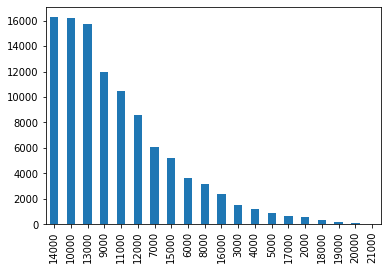

In [77]:
train_df['ANNUAL_MILEAGE'].value_counts().plot(kind='bar')

In [78]:
# 15000 -21000 (15 and above)
l1 = [14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000]
train_df['ANNUAL_MILEAGE'] = train_df['ANNUAL_MILEAGE'].replace(l1,'14+')
test_df['ANNUAL_MILEAGE'] = test_df['ANNUAL_MILEAGE'].replace(l1,'14+')

In [79]:
# 315+158+78+5+620+2365+5191 = 8732
train_df['ANNUAL_MILEAGE'].value_counts(dropna=False)

14+      24998
10000    16205
13000    15750
9000     11986
11000    10474
12000     8564
7000      6043
6000      3652
8000      3160
3000      1515
4000      1180
5000       921
2000       552
Name: ANNUAL_MILEAGE, dtype: int64

In [80]:
# 2000 - 6000 
l2 = [2000, 3000, 4000, 5000, 6000]
train_df['ANNUAL_MILEAGE'] = train_df['ANNUAL_MILEAGE'].replace(l2,'2000-6000')
test_df['ANNUAL_MILEAGE'] = test_df['ANNUAL_MILEAGE'].replace(l2,'2000-6000')

In [81]:
# 552+1515+1180+921+3652 = 7820
train_df['ANNUAL_MILEAGE'].value_counts(dropna=False)

14+          24998
10000        16205
13000        15750
9000         11986
11000        10474
12000         8564
2000-6000     7820
7000          6043
8000          3160
Name: ANNUAL_MILEAGE, dtype: int64

In [82]:
# 7000 - 8000
l3 = [7000, 8000,9000]
train_df['ANNUAL_MILEAGE'] = train_df['ANNUAL_MILEAGE'].replace(l3,'7000-9000')
test_df['ANNUAL_MILEAGE'] = test_df['ANNUAL_MILEAGE'].replace(l3,'7000-9000')

In [83]:
# 6043+3160 = 9203
train_df['ANNUAL_MILEAGE'].value_counts(dropna=False)

14+          24998
7000-9000    21189
10000        16205
13000        15750
11000        10474
12000         8564
2000-6000     7820
Name: ANNUAL_MILEAGE, dtype: int64

In [84]:
# 100000-11000
l4 = [10000, 11000]
train_df['ANNUAL_MILEAGE'] = train_df['ANNUAL_MILEAGE'].replace(l4,'10000-11000')
test_df['ANNUAL_MILEAGE'] = test_df['ANNUAL_MILEAGE'].replace(l4,'10000-11000')

In [85]:
# 120000-13000
l4 = [12000, 13000]
train_df['ANNUAL_MILEAGE'] = train_df['ANNUAL_MILEAGE'].replace(l4,'12000-13000')
test_df['ANNUAL_MILEAGE'] = test_df['ANNUAL_MILEAGE'].replace(l4,'12000-13000')

In [86]:
train_df['ANNUAL_MILEAGE'].value_counts(dropna=False)

10000-11000    26679
14+            24998
12000-13000    24314
7000-9000      21189
2000-6000       7820
Name: ANNUAL_MILEAGE, dtype: int64

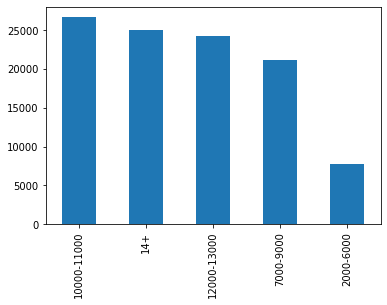

In [87]:
train_df['ANNUAL_MILEAGE'].value_counts().plot(kind='bar')

In [88]:

# Difine Dict with the key-value pair to remap.
mile_dict = {"2000-6000" : 0, "7000-9000" : 1, "10000-11000": 2, "12000-13000": 3, "14+": 4}
train_df = train_df.replace({"ANNUAL_MILEAGE": mile_dict})
test_df = test_df.replace({"ANNUAL_MILEAGE": mile_dict})

In [89]:
train_df.shape

(105000, 30)

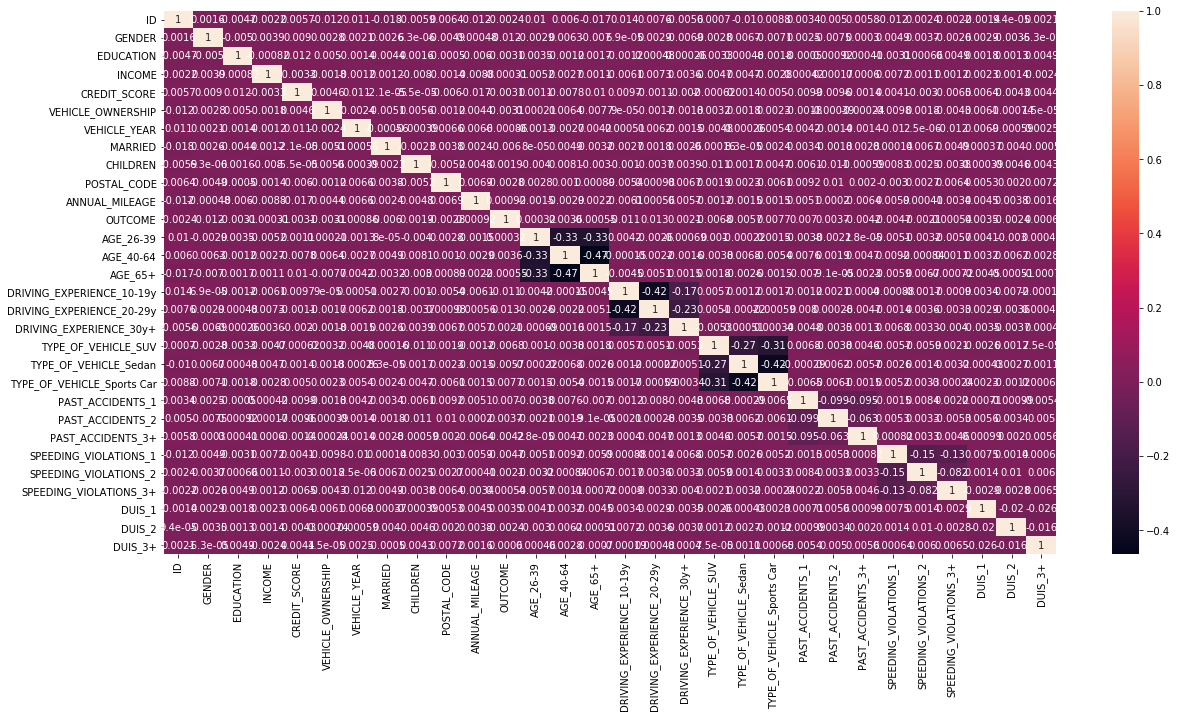

In [90]:
# Plot the correlation matrix for all variables
corr_matrix = train_df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix,annot=True)
plt.show()

In [93]:
# Split into independent and dependent variables
X = train_df.drop('OUTCOME',axis=1)
y = train_df['OUTCOME']
print(X.shape,y.shape)

(105000, 29) (105000,)


In [94]:
# Split into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,train_size = 0.7, random_state = 100)
print("Train dataset:",X_train.shape)
print("Test dataset:",X_test.shape)

Train dataset: (73500, 29)
Test dataset: (31500, 29)


In [95]:
# Scaling numerical columns for train dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler=MinMaxScaler()
num_cols = X_train.select_dtypes(include=['float64','int64','uint8','int32']).columns
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_train.head()

,ID,GENDER,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,AGE_26-39,AGE_40-64,AGE_65+,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,TYPE_OF_VEHICLE_SUV,TYPE_OF_VEHICLE_Sedan,TYPE_OF_VEHICLE_Sports Car,PAST_ACCIDENTS_1,PAST_ACCIDENTS_2,PAST_ACCIDENTS_3+,SPEEDING_VIOLATIONS_1,SPEEDING_VIOLATIONS_2,SPEEDING_VIOLATIONS_3+,DUIS_1,DUIS_2,DUIS_3+
41575,0.724661,0.0,1.0,0.666667,0.760805,1.0,1.0,0.0,0.0,0.000000,0.25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20113,0.305405,1.0,0.0,1.000000,0.516310,1.0,1.0,1.0,1.0,0.000000,0.25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97947,0.550906,1.0,0.0,1.000000,0.533329,1.0,0.0,1.0,0.0,0.000000,0.50,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60886,0.157086,1.0,1.0,0.666667,0.872419,1.0,1.0,0.0,1.0,0.000000,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
56259,0.669365,0.0,1.0,1.000000,0.969256,1.0,0.0,1.0,0.0,0.287908,0.50,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [96]:
# Apply Scaling to test dataset
# num_cols = X_test.select_dtypes(include=['float64','int64']).columns
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_test.head()

,ID,GENDER,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,AGE_26-39,AGE_40-64,AGE_65+,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,TYPE_OF_VEHICLE_SUV,TYPE_OF_VEHICLE_Sedan,TYPE_OF_VEHICLE_Sports Car,PAST_ACCIDENTS_1,PAST_ACCIDENTS_2,PAST_ACCIDENTS_3+,SPEEDING_VIOLATIONS_1,SPEEDING_VIOLATIONS_2,SPEEDING_VIOLATIONS_3+,DUIS_1,DUIS_2,DUIS_3+
53620,0.278403,0.0,1.0,1.000000,0.477223,1.0,0.0,0.0,1.0,0.000000,1.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60370,0.195163,0.0,0.0,0.333333,0.712326,0.0,1.0,1.0,1.0,0.240451,1.00,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44788,0.894169,1.0,0.0,0.666667,0.548966,1.0,1.0,1.0,0.0,0.000000,0.25,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29000,0.554527,1.0,0.5,0.000000,0.551211,1.0,0.0,1.0,0.0,0.055019,0.50,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19049,0.024331,1.0,0.0,0.333333,0.643114,0.0,0.0,1.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
test_df[num_cols] = scaler.transform(test_df[num_cols])
test_df.head()

,ID,GENDER,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,AGE_26-39,AGE_40-64,AGE_65+,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,TYPE_OF_VEHICLE_SUV,TYPE_OF_VEHICLE_Sedan,TYPE_OF_VEHICLE_Sports Car,PAST_ACCIDENTS_1,PAST_ACCIDENTS_2,PAST_ACCIDENTS_3+,SPEEDING_VIOLATIONS_1,SPEEDING_VIOLATIONS_2,SPEEDING_VIOLATIONS_3+,DUIS_1,DUIS_2,DUIS_3+
0,0.352871,1.0,0.0,0.333333,0.843192,1.0,1.0,0.0,1.0,0.000000,0.50,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.038483,0.0,0.5,1.000000,0.312516,1.0,0.0,0.0,0.0,0.291157,0.75,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.503984,1.0,0.0,1.000000,0.624434,0.0,1.0,1.0,0.0,0.000000,0.75,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.202328,1.0,0.5,1.000000,0.702196,1.0,1.0,1.0,1.0,0.000000,1.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.527878,1.0,0.0,0.666667,0.776622,0.0,1.0,0.0,1.0,1.000000,1.00,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## LIGHTGBM

In [98]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(objective='binary', random_state=1, n_jobs=-1)
lgbm.fit(X_train, y_train)

LGBMClassifier(objective='binary', random_state=1)

In [99]:
preds = lgbm.predict_proba(X_train)

In [100]:
log_loss(y_train,preds) #0.6609

0.6609273881848235

In [101]:
log_loss(y_test,lgbm.predict_proba(X_test)) #0.6829

0.6829154121697805

In [102]:
res = lgbm.predict_proba(test_df)

In [103]:
pd.DataFrame(res).to_csv("result.csv",index=False,header=False) #0.6865

## Train: 0.66
## Test:  0.68
## Final: 0.6865

## LIGHTGBM WITH GRID SEARCH

In [104]:
from sklearn.model_selection import GridSearchCV

In [105]:
params = {
    'application': 'binary', # for binary classification
#     'num_class' : 1, # used for multi-classes
    'boosting': 'gbdt', # traditional gradient boosting decision tree
    'num_iterations': 100, 
    'learning_rate': 0.05,
    'num_leaves': 62,
    'max_depth': -1, # <0 means no limit
    'max_bin': 510, # Small number of bins may reduce training accuracy but can deal with over-fitting
    'lambda_l1': 5, # L1 regularization
    'lambda_l2': 10, # L2 regularization
    'metric' : 'binary_error',
    'subsample_for_bin': 200, # number of samples for constructing bins
    'subsample': 1, # subsample ratio of the training instance
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.5, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 5# minimum number of data needed in a leaf
}

In [106]:
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'])

In [107]:
gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 3456 candidates, totalling 13824 fits


C:\Users\welcome\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.005, 'max_bin': 255, 'n_estimators': 8, 'num_leaves': 6, 'objective': 'binary', 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
0.576734693877551


In [111]:
pred1 = grid.predict_proba(X_train)

In [112]:
log_loss(y_train,pred1)

0.6812949609759675

In [113]:
log_loss(y_test,grid.predict_proba(X_test)) #0.6806

0.6806809648374486

In [114]:
res = grid.predict_proba(test_df)

In [115]:
pd.DataFrame(res).to_csv("result1.csv",index=False,header=False) #0.68051

### Age and driving experience:
    A person falling in the age group 16-25 can't have 30y+ driving experience. Let's test this hypothesis 

In [ ]:
age_1625 = train_df[train_df['AGE'] =='16-25']
age_1625['DRIVING_EXPERIENCE'].value_counts(dropna=False)

In [ ]:
age_1625_drive_30 = age_1625[age_1625['DRIVING_EXPERIENCE']=='30y+']

In [ ]:
age_1625_drive_30.head(50)

In [ ]:
age_1625_drive_30['POSTAL_CODE'].value_counts(dropna=False)

In [ ]:
age_2639 = train_df[train_df['AGE'] =='26-39']
age_2639['DRIVING_EXPERIENCE'].value_counts(dropna=False)

In [ ]:
train_df['DRIVING_EXPERIENCE'].value_counts(dropna=False)

In [ ]:
dum_test_df = pd.get_dummies(data=test_df[dum_cols], columns= dum_cols,drop_first = True)
dum_test_df.head()

In [ ]:
print(dum_test_df.shape)
print(df_cat_cols.shape)

In [ ]:
# Split the dateset into train and test datasets
y = new_train_df['OUTCOME']
X = new_train_df.drop(columns=['OUTCOME'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

In [ ]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(objective='binary')
clf.fit(X_train, y_train)

In [ ]:
clf.predict_proba(X_test)

In [ ]:
log_loss(y_test,clf.predict_proba(X_test))

## Logistic

In [ ]:
slr = LogisticRegression(random_state=42)

In [ ]:
slr.fit(X_train,y_train)

In [ ]:
y_pred = slr.predict(X_train)

In [ ]:
log_loss(y_test,slr.predict_proba(X_test))

In [ ]:
y_test_pred = slr.predict(new_test_df)

In [ ]:
len(y_test_pred)

## Grid search with logistic regression

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
default_params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
clf0 = GridSearchCV(estimator=slr, scoring='roc_auc', param_grid=default_params, return_train_score=True, verbose=1, cv=5)
clf0.fit(X_train, y_train.values.ravel())

In [ ]:
# Check the best scores
print(clf0.best_score_)
print(clf0.best_estimator_)

In [ ]:
logreg1 = clf0.best_estimator_
log_loss(y_test,logreg1.predict_proba(X_test))

# Second grid search

In [ ]:
default_params = {'penalty':['l1', 'l2', 'elasticnet', 'none']}
clf1 = GridSearchCV(estimator=logreg1, scoring='roc_auc', param_grid=default_params, return_train_score=True, verbose=1, cv=5)
clf1.fit(X_train, y_train.values.ravel())

In [ ]:
# Check the best scores
print(clf1.best_score_)
print(clf1.best_estimator_)

In [ ]:
logreg2 = clf1.best_estimator_
log_loss(y_test,logreg2.predict_proba(X_test))

### THIRD GRID SEARCH

In [ ]:
default_params = {'penalty':['l1', 'l2', 'elasticnet'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'multi_class': ['auto', 'ovr']}
clf1 = GridSearchCV(estimator=slr, scoring='accuracy', param_grid=default_params, return_train_score=True, verbose=1, cv=5)
clf1.fit(X_train, y_train.values.ravel())


In [ ]:
# Check the best scores
print(clf1.best_score_)
print(clf1.best_estimator_)

In [ ]:
logreg2 = clf1.best_estimator_
log_loss(y_test,logreg2.predict_proba(X_test))

In [ ]:
0.6812169176920452
0.681215037546723

In [ ]:
preds_cv1_eval = logreg2.predict_proba(new_test_df)


In [ ]:
pd.DataFrame(preds_cv1_eval).to_csv("submission_1_02112022.csv",index=False,header=False)

In [ ]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())